## Import packages

In [1]:
from utils.FloorplanToBlenderLib import *
from PIL import Image
# from IPython.display import display
import cv2
import numpy as np
import pandas as pd
import math
import random 
import easyocr
import ctypes
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

### img process

In [4]:
def remove_noise(img):
    # get binary image
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to gray
    thresh = cv2.threshold(img_gray, 135, 255, cv2.THRESH_BINARY)[1] # convert to binary
    img = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    
    # contour hierarchy
    regions, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # detect all elements
    countour_list = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        countour_list.append([x, y, w, h])
    
    # get 2nd largest contour
    countour_list = np.asarray(countour_list)  # convert to numpy-array
    column_values = ['left', 'top', 'width', 'height']
    df = pd.DataFrame(data = countour_list, columns = column_values)
    df = df.sort_values(by='width', ascending=False)

    index = df.iloc[1]
    x, y, w, h = index['left'], index['top'], index['width'], index['height']

    
    # remove outside noise
    img[:, :x] = [255, 255, 255]
    img[x + w + 1:, :] = [255, 255, 255]
    img[:y, :] = [255, 255, 255]
    img[y + h + 1:, :] = [255, 255, 255]
    
    return img

def run_once(f):
    def wrapper(*args, **kwargs):
        if not wrapper.has_run:
            wrapper.has_run = True
            return f(*args, **kwargs)
    wrapper.has_run = False
    return wrapper

@run_once
def load_easyocr_model():
    # only needs to run once to load the model into memory
    reader = easyocr.Reader(['ch_tra','en'])
    return reader

def impl_model(img):
    # get words position
    result = reader.readtext(img,
                             detail=1,
                             paragraph=True, # Combine result into paragraph
                             x_ths=0.1, # Maximum horizontal distance to merge text boxes when paragraph=True
                             y_ths=0.5, # Maximum verticall distance to merge text boxes when paragraph=True
                             # width_ths=0.1,
                             # height_ths=0.1,
                             mag_ratio=1.2,
                             )
    return result



def get_words_position(img):
    cp_list = []
    
    # load easyocr to get words position
    words_result = impl_model(img)
    
    for word in words_result:        
        # get center point of each word
        x = (word[0][1][1] + word[0][2][1]) / 2  # gey x
        y = (word[0][0][0] + word[0][1][0]) / 2  # get y
        
        # put in center of gravity list
        cp_list.append([[y, x], word[1]])

    return cp_list


def get_boxes(img):
    # get boxes
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = detect.wall_filter(gray)

    gray = ~gray

    rooms, colored_rooms = detect.find_rooms(gray.copy())

    gray_rooms =  cv2.cvtColor(colored_rooms, cv2.COLOR_BGR2GRAY)

    # get box positions for rooms
    boxes, gray_rooms = detect.detectPreciseBoxes(gray_rooms, gray_rooms)
    
    return boxes, gray_rooms


def correct_name(val):
    # correct to the right room name
    bed_room = ['堅', '臥 室', '臥 堂', '室', '臥室']
    bth_room = ['瑜', '}', '沿廁', '浴廁']
    d_room = ['餐廳']
    l_room = ['客廳']
    kit = ['麝','房', '廚房']
    
    if val in bed_room: val = '臥室' # bedroom
        
    elif val in bth_room: val = '浴廁' # bathroom
        
    elif val in d_room: val = '餐廳' # dining room
        
    elif val in l_room: val = '客廳' # living room
    
    elif val in kit: val = '廚房' # kitchen
        
    else: val = '其他' # others
        
    return val


def get_room_dict(img):
    
    # build room dictionary
    room_dict = {
        '臥室':[],
        '浴廁':[],
        '餐廳':[],
        '客廳':[],
        '廚房':[],
        '其他':[],
    }
    
    # get room contour
    boxes, gray_rooms = get_boxes(img)
    
    # get center point of each room type
    cp_list = get_words_position(img)
    
    for box in boxes:
        area = cv2.contourArea(box)
        new_arr = np.reshape(np.ravel(box), (-1, 2)) # equivalent to C ravel then C reshape
        box = new_arr.tolist() # convert to python scalar
        
        # check whether the point in the box 
        polygon = Polygon(box)
        for cp in cp_list:
            point = Point(cp[0]) # cp[0] => coordinate 
            
            # if yes, add to the room dictionary
            if polygon.contains(point):
                val = correct_name(cp[1]) # check and correct to the right room name
                room_dict[val].append([box, area])

    return room_dict


def get_info(img, select_room_type):
    
    # get room coordinate and type
    room_dict = get_room_dict(img)
    
    # get coordinate(s) of specific room type
    info_list = room_dict[select_room_type]
        
    return info_list



def check_room_size(img):
    room_dict = get_room_dict(img)
    
    # set list for bedroom & living room
    b_list = room_dict['臥室']
    l_list = room_dict['客廳']

    # set list for bedroom & kitchen
    bth_list = room_dict['浴廁']
    kit_list = room_dict['廚房']
    
    err_list = []
    # check wether bedroom > living room
    for i in b_list:
        for j in l_list:
            if i[1] > j[1]:
                # print(f'臥室 > 客廳:\n{i[1]} > {j[1]}')
                # contour_drawing(img, i[0])
                # contour_drawing(img, j[0])
                if i[1] not in err_list: err_list.append(i[0])
                if j[1] not in err_list: err_list.append(j[0])
    
    # check wether bathroom > kitchen
    for i in bth_list:
        for j in kit_list:
            if i[1] > j[1]:
                # print(f'廁所 > 廚房:\n{i[1]} > {j[1]}')
                # contour_drawing(img, i[0])
                # contour_drawing(img, j[0])
                if i[1] not in err_list: err_list.append(i[0])
                if j[1] not in err_list: err_list.append(j[0])

    return err_list


def contour_drawing(img, err_list):
    
    if err_list:
        print('gotcha')
        
        i = 0
        while i < len(err_list):
            pts = np.array(err_list[i])

            img = cv2.polylines(img,
                                [pts],
                                True, # isClosed
                                (255, 0, 0), # color
                                2, # thickness
                               )
            i += 1
    else: print('not find error')
    
    return img

# Only needs to run once to load the model into memory
global reader
reader = easyocr.Reader(['ch_tra','en']) 

### implementing model

gotcha


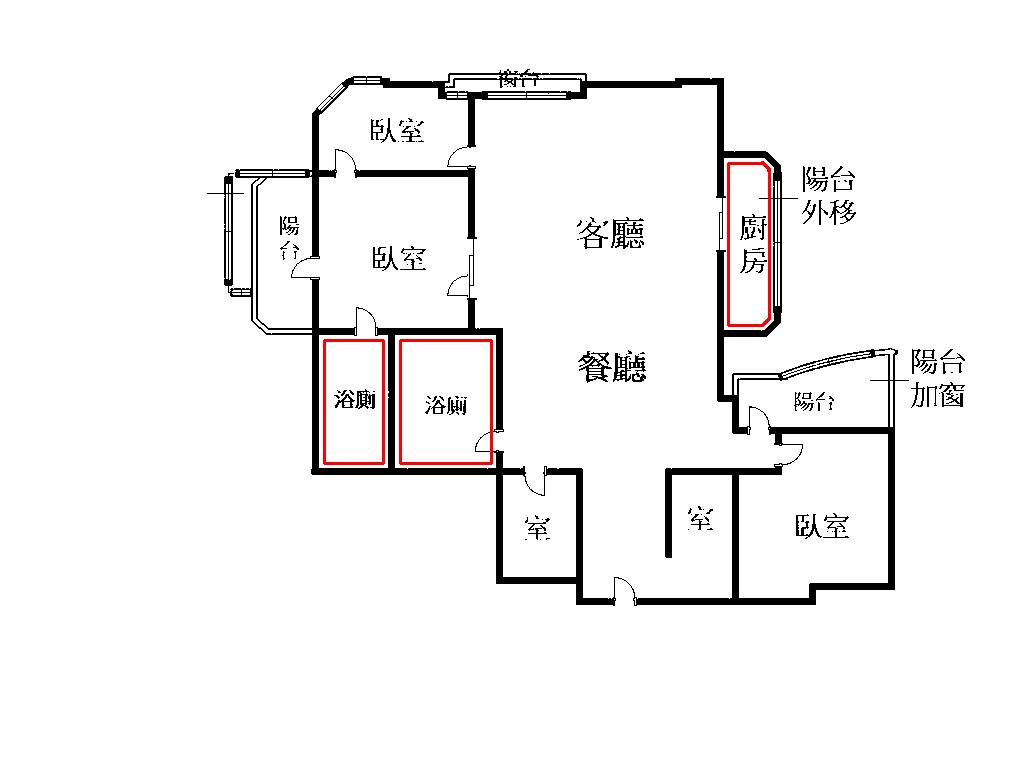

In [6]:
# load image
img = cv2.imread("images/44.jpg")

# process
img = remove_noise(img)

# check fengshui error
check_img = img.copy() 

err_list = check_room_size(check_img)

contour_drawing(check_img, err_list)

    
display(Image.fromarray(check_img))

### Adjust reference to check if the text is recognized

In [ ]:
# image process
check_img = img.copy()

result = load_easyocr_model(check_img)

for i in result:
    
    p1x = round(i[0][0][0])
    p1y = round(i[0][0][1])
    p2x = round(i[0][2][0])
    p2y = round(i[0][2][1])
    cv2.rectangle(check_img, (p1x, p1y), (p2x, p2y), (0,255,0),3)
    
    # cx = round(i[0][0])
    # cy = round(i[0][1])
    # cv2.circle(test,(cx,cy), 10, (0,0,255), -1)
    
    print(f'{i[0]} ==> {i[1]}')

display(Image.fromarray(check_img))

### Detect Contours (Object Filter)

In [ ]:
boxes, gray_rooms = get_boxes(img)
display(Image.fromarray(img))
display(Image.fromarray(gray_rooms))

In [ ]:
test_dict = get_room_dict(img)
test_dict

### Check

In [ ]:
def contour_drawing(img, lst):
    pts = np.array(lst)

    img = cv2.polylines(img,
                        [pts],
                        True, # isClosed
                        (255, 0, 0), # color
                        2, # thickness
                       )
    return img


def find_fengshui_error(img):
    room_dict = get_room_dict(img)
    
    # set list for bedroom & living room
    b_list = room_dict['臥室']
    l_list = room_dict['客廳']

    # set list for bedroom & kitchen
    bth_list = room_dict['浴廁']
    kit_list = room_dict['廚房']

    
    # check wether bedroom > living room
    for i in b_list:
        for j in l_list:
            if i[1] > j[1]:
                print(f'臥室 > 客廳:\n{i[1]} > {j[1]}')
                contour_drawing(img, i[0])
                contour_drawing(img, j[0])
    
    # check wether bathroom > kitchen
    for i in bth_list:
        for j in kit_list:
            if i[1] > j[1]:
                print(f'廁所 > 廚房:\n{i[1]} > {j[1]}')
                contour_drawing(img, i[0])
                contour_drawing(img, j[0])

    display(Image.fromarray(img))

In [ ]:
show_error = img.copy()

test_lst = [[557, 147], [557, 262], [622, 262], [622, 147]]
err = [[698, 73], [698, 120], [834, 120], [834, 73]]

show_error = contour_drawing(show_error, test_lst)
show_error = contour_drawing(show_error, err)

display(Image.fromarray(show_error))

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [ ]:
# only for check room type
n = len(info_list)

rnd = random.randint(0, n -1)
# rnd=6

test_bgr = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

pts = np.array(info_list[rnd][0])
 
# Using cv2.polylines() method drawing the contour
test_bgr = cv2.polylines(test_bgr, 
                         [pts],
                         True, # isClosed 
                         (255, 0, 0), # color 
                         2, # thickness
                        )

print(f'coord: {info_list[rnd][0]}\narea: {info_list[rnd][1]}')
display(Image.fromarray(test_bgr))

In [ ]:
for i in room_list:
    print(i)

In [ ]:
# from memory get value
# for i in mem_list:
#     val = ctypes.cast(i, ctypes.py_object).value
#     print(val)


### Monument for Mingyao's code

In [ ]:
for index,value in enumerate(box_pos):
    for i,j in xylist:
        print(value.min(axis=1).max())
        print(value.min(axis=1).min())
        print(i)
        if i > value.min(axis=1).min() and i < value.min(axis=1).max():
            print('yes')
        else:
            print('no')
    # print(value)